# TODO  checkout why y does not fit properly and samping fails etc.

In [1]:
#%pip install jupyter
# TODO check out hwy y doe snot fit correclty
# TODO thetas 
# TODO check out hs for y


In [2]:
#%pip install -i https://test.pypi.org/simple --extra-index-url https://pypi.org/simple tramdag

In [3]:
import os
from tramdag import TramDagModel, TramDagConfig

In [4]:
cfg=TramDagConfig()
cfg.setup_configuration(EXPERIMENT_DIR='exp_untrained_initweigths/', experiment_name='dumm1') # works also without arguments, then default paths are used

Configuration already exists: exp_untrained_initweigths/configuration.json


In [5]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'T':'continous', 
            'x2':'continous',
            'y':'continous'} 

cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
T                    | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
y                    | continous       | continuous [c]                 | continuous [c]                
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at exp_untrained_init

/home/bule/TramDag/tramdag/utils/configuration.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


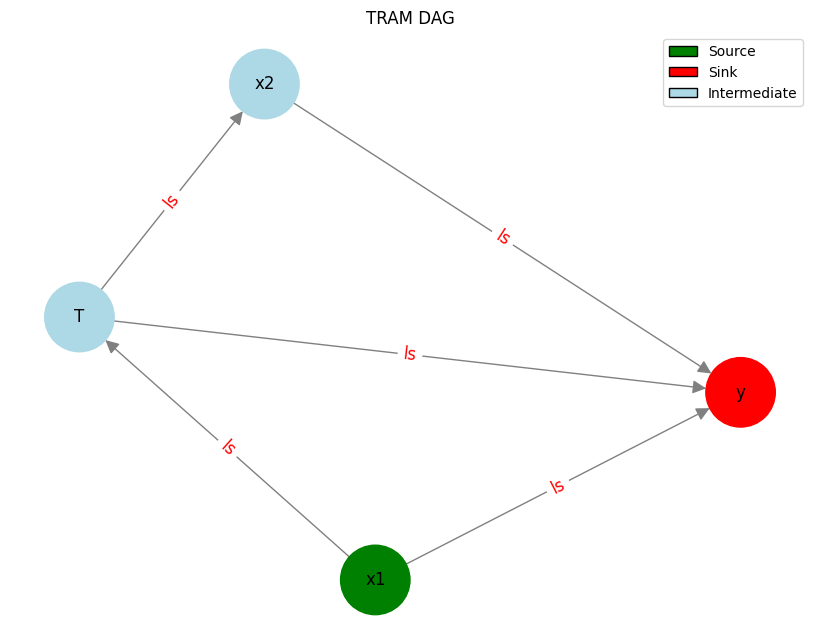

In [6]:
cfg.set_meta_adj_matrix(seed=123) #Create the (Meta) Adjacency Matrix

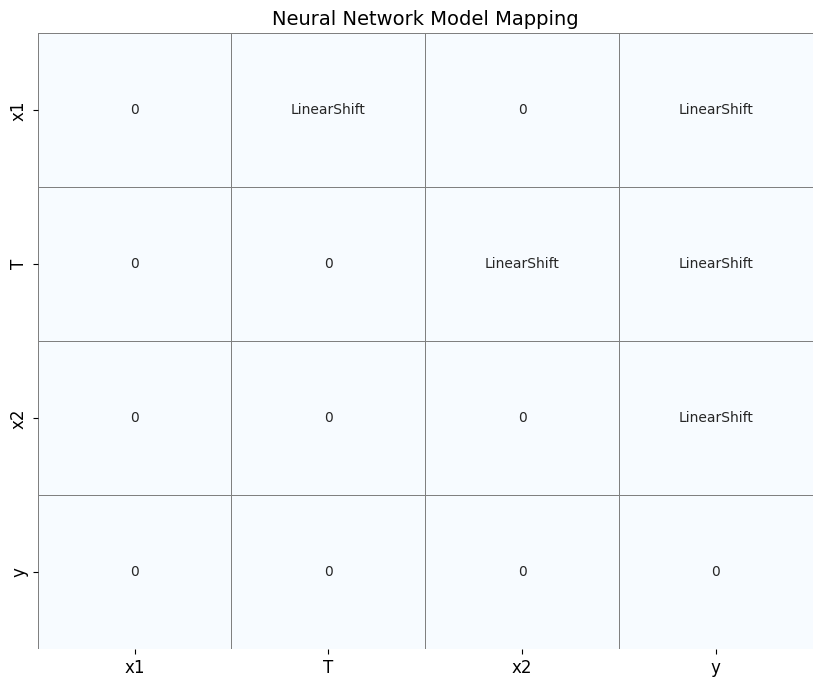

In [7]:
cfg.set_tramdag_nn_models() 
#Create the NN models one per node
# Create names for the models, which then can be to define different architectures for different nodes

All is in the configuration file now, so we delete cfg and load the configuration file

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
np.random.seed(43)
# Ja, sag mal, X1 ist uniform verteilt zwischen 0 und 2.
# T Modelliert als logistische Regression in Abhängigkeit von x1 mit dem Koeffizienten 2. 
# x2 ist normalverteilt mit Mittelwert 0 und Standardabweichung 1.
n = 10    
x1 = np.random.uniform(0, 2, size=(n, 1))
T = np.random.binomial(1, 1 / (1 + np.exp(-2 * x1)))
x2 = -1*T + np.random.normal(0,0.1, size=(n, 1))
y = 4*T + 2*x2 + 3*x1 + np.random.normal(0, 0.1, size=(n, 1))
df = pd.DataFrame({'x1': x1.flatten(), 'T': T.flatten(), 'x2': x2.flatten(), 'y': y.flatten()})

print(df.head())


# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

         x1  T        x2         y
0  0.230109  1 -0.950709  2.794354
1  1.218133  1 -1.012431  5.717955
2  0.266782  1 -0.806486  3.176575
3  0.481179  1 -1.061844  3.375410
4  0.654278  0 -0.104684  1.792957


In [9]:
cfg = TramDagConfig.load_json('exp_untrained_initweigths/configuration.json')
cfg.compute_levels(df=train_df)

In [10]:
from tramdag import TramDagModel
#cfg.compute_levels(train_df) #Calculate the levels from the training file


$$
u2 = h(x2|T=1)
$$

$$
x2 = h^{-1}(u2|T=1)
$$

$$
x2 = h^{-1}(h(x2|T=1)|T=1)
$$


$$
uy = h(y|T=1, x1,x2) \\
y = h^{-1}(uy|T=1, x1,x2) \\
y = h^{-1}(h(y|T=1, x1,x2)|T=1, x1,x2)

$$

In [11]:
device='cpu'
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data =train_df )
# Created the model from the configuration
# If weight initialization is set to True then R code like Polar... is used to initialize the weights

In [12]:
epochs = 10

td_model.fit(train_df, val_df,
            #  train_list=['y'], #Training only on a subset of the model
             learning_rate=1e-2,
             epochs=epochs,batch_size=1000,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,       #For DataLoader
             train_mode = "sequential") #Parallel is better for many nodes


[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to exp_untrained_initweigths/min_max_scaling.json
[INFO] Training 4 nodes (sequential) on cpu

[INFO] Training node 'x1' for 10 epochs on cpu (pid=1303114)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'T' for 10 epochs on cpu (pid=1303114)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x2' for 10 epochs on cpu (pid=1303114)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'y' for 10 epochs on cpu (pid=1303114)
[INFO] Existing model found. Loading weights and history from LAST model...


[INFO] Loaded training/validation histories for 4 nodes.


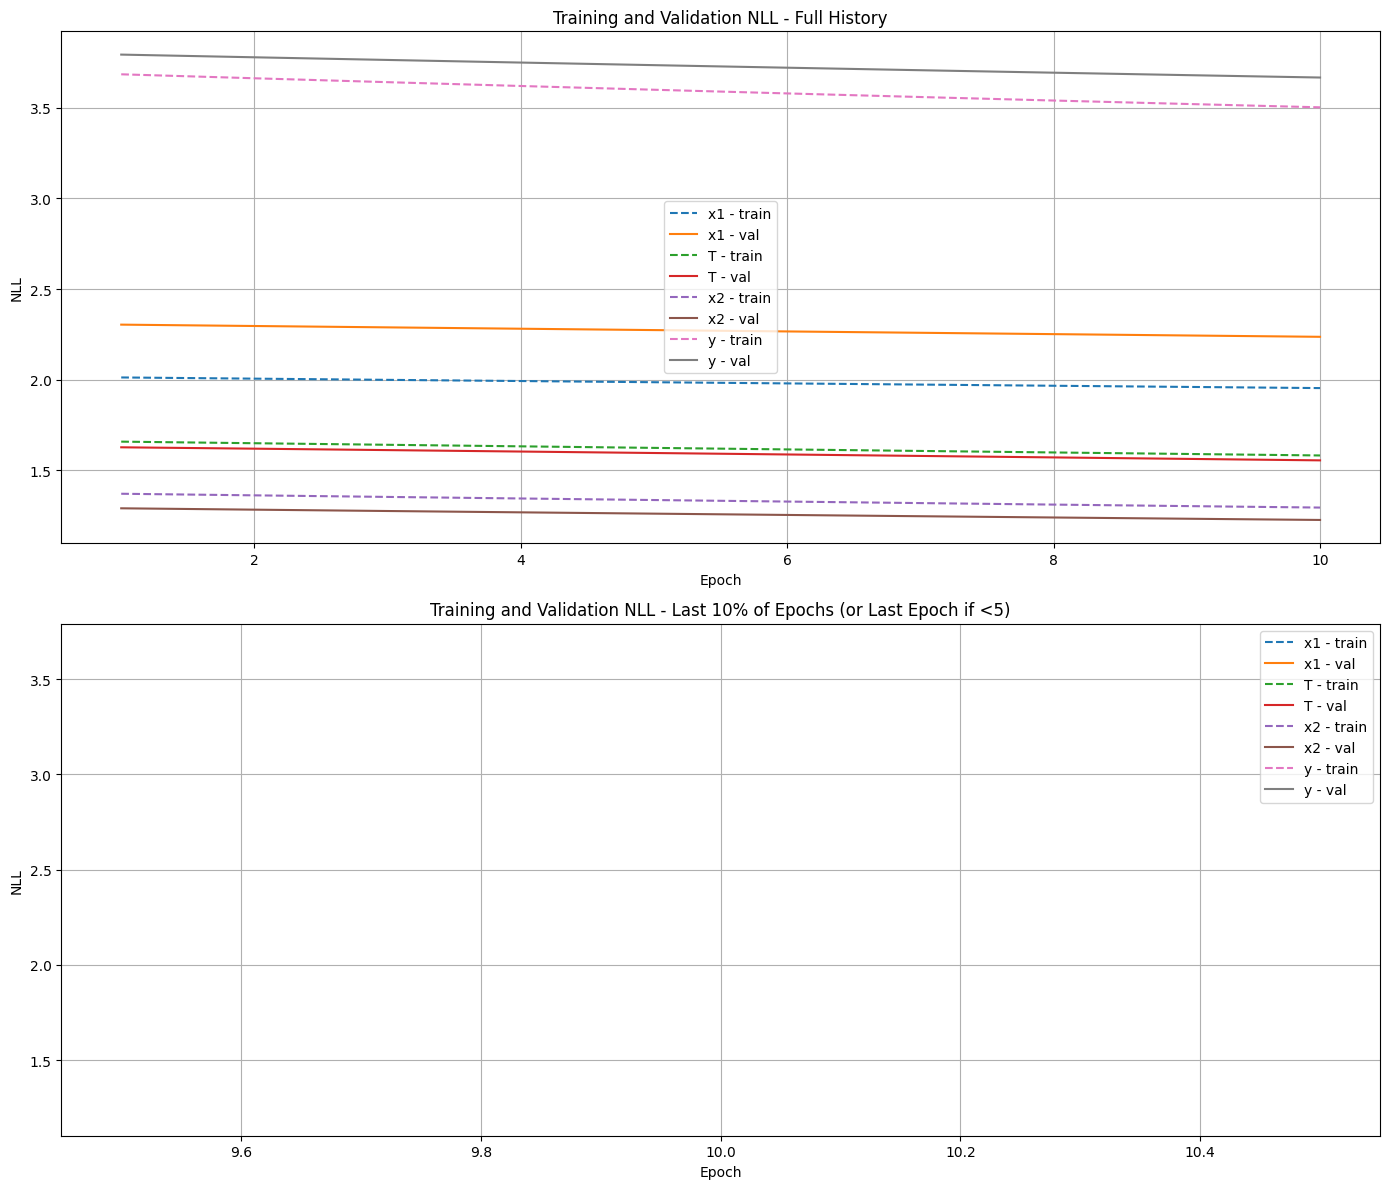

In [13]:
td_model.plot_loss_history()

[WARNING] No linear shift history found for node 'x1' at exp_untrained_initweigths/x1/linear_shifts_all_epochs.json


/home/bule/TramDag/tramdag/TramDagModel.py:928: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


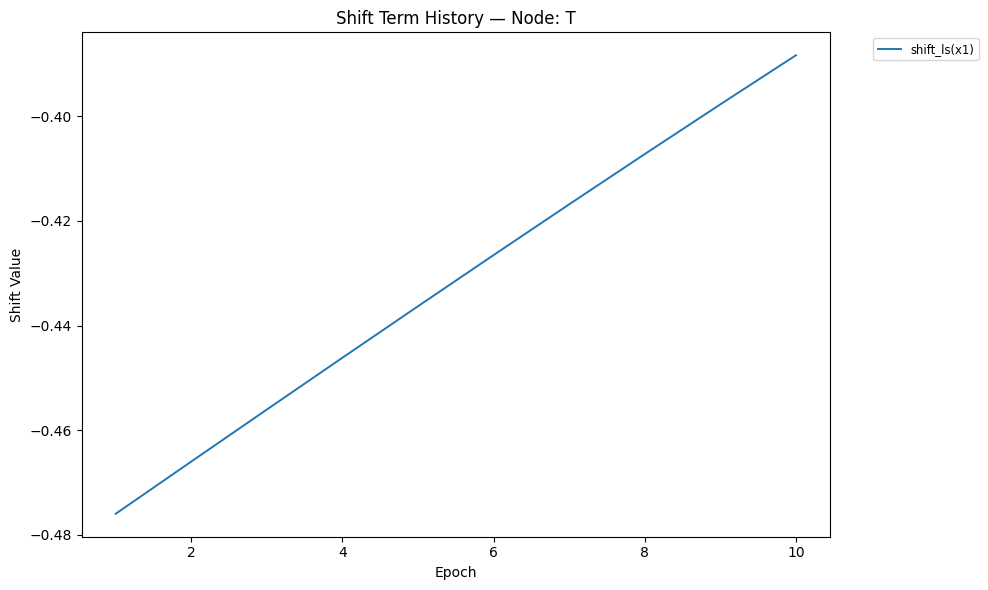

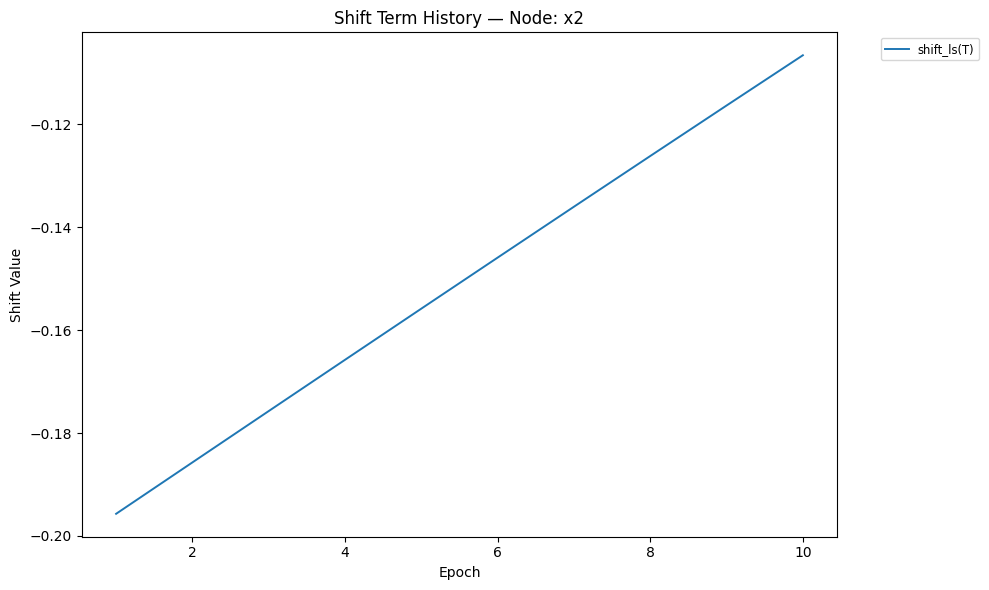

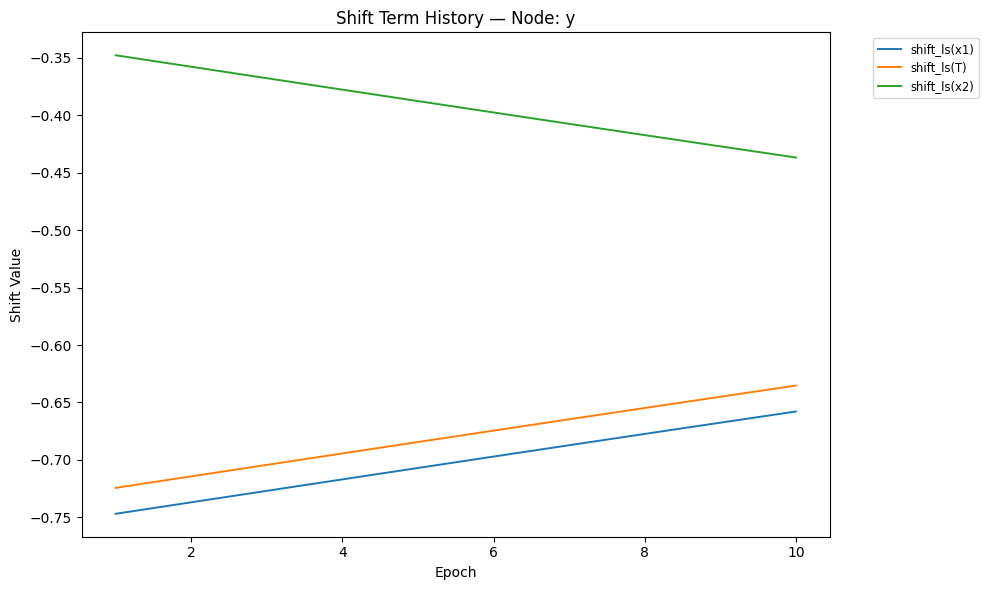

In [14]:
td_model.plot_linear_shift_history()

In [15]:
## td_model.linear_shift_history()

In [16]:
# intercept_hist=td_model.simple_intercept_history()

In [17]:

# def to_theta(h):
#     # Construct d = [0 | h1 | softplus(h2:)]
#     d = torch.cat((
#         torch.zeros((h.shape[0], 1), device=h.device),
#         h[:, 0:1],
#         F.softplus(h[:, 1:h.shape[1]])
#     ), dim=1)
    
#     # Compute cumulative sum along columns, skipping first column
#     theta = torch.cumsum(d[:, 1:], dim=1)
#     return theta


# # transform_intercepts_continous(ep1)
# print("Theta tilde:", theta_tilde_reshaped)

# theta=to_theta(theta_tilde_reshaped)
# print("theta",theta)

# first_vers=transform_intercepts_continous(theta_tilde_reshaped)
# print("first_vers_to_theta",first_vers)

In [18]:
td_model.simple_intercept_history()['x1']

,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,epoch_9,epoch_10
0,[-7.683862686157227],[-7.673883438110352],[-7.663941860198975],[-7.654055595397949],[-7.644245147705078],[-7.634533405303955],[-7.624944686889648],[-7.615508079528809],[-7.60625410079956],[-7.597218036651611]
1,[-7.099047660827637],[-7.084628582000732],[-7.070222854614258],[-7.055848121643066],[-7.041525363922119],[-7.027276992797852],[-7.013128757476807],[-6.99910831451416],[-6.98524808883667],[-6.9715824127197275]
2,[-6.535564422607422],[-6.5168256759643555],[-6.49807596206665],[-6.4793338775634775],[-6.460619449615478],[-6.441956520080566],[-6.423369884490967],[-6.40488862991333],[-6.386544227600098],[-6.368371963500977]
3,[-5.224384784698486],[-5.198332786560059],[-5.1722517013549805],[-5.146161079406738],[-5.120082378387451],[-5.094039916992187],[-5.068059921264648],[-5.042171478271484],[-5.016407012939453],[-4.990803241729736]
4,[-4.620117664337158],[-4.589518070220947],[-4.558865547180176],[-4.528179168701172],[-4.497481346130371],[-4.466795444488525],[-4.436148643493652],[-4.40557050704956],[-4.375093936920166],[-4.344754695892334]
5,[-3.90526270866394],[-3.869543552398681],[-3.833747148513794],[-3.797893524169922],[-3.762004375457763],[-3.726104021072387],[-3.690220117568969],[-3.6543819904327393],[-3.618623256683349],[-3.582980155944824]
6,[-3.453418731689453],[-3.414052724838257],[-3.374586582183838],[-3.335040330886841],[-3.295435905456543],[-3.255797863006592],[-3.216153383255005],[-3.176532506942749],[-3.136968612670898],[-3.097497940063476]
7,[-3.112828969955444],[-3.070566415786743],[-3.028182983398437],[-2.985699415206909],[-2.9431371688842773],[-2.900520801544189],[-2.857877731323242],[-2.815237998962402],[-2.772634983062744],[-2.730104923248291]
8,[-2.409420490264892],[-2.36209487915039],[-2.314624786376953],[-2.267030715942383],[-2.219334602355957],[-2.171562194824218],[-2.123740673065185],[-2.075900554656982],[-2.028076171875],[-1.980303764343261]
9,[-1.265116691589355],[-1.210966110229492],[-1.156651020050048],[-1.102193355560302],[-1.047616481781005],[-0.992946624755859],[-0.9382114410400391],[-0.8834433555603021],[-0.828676700592041],[-0.773950099945068]


In [19]:
td_model.minmax_dict

{'x1': [0.24294461123690445, 1.630502545629375],
 'T': [0.35000000000000003, 1.0],
 'x2': [-1.0794706361873667, -0.35031476404496714],
 'y': [2.143446089297207, 6.808888827024275]}

/home/bule/TramDag/tramdag/TramDagModel.py:985: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


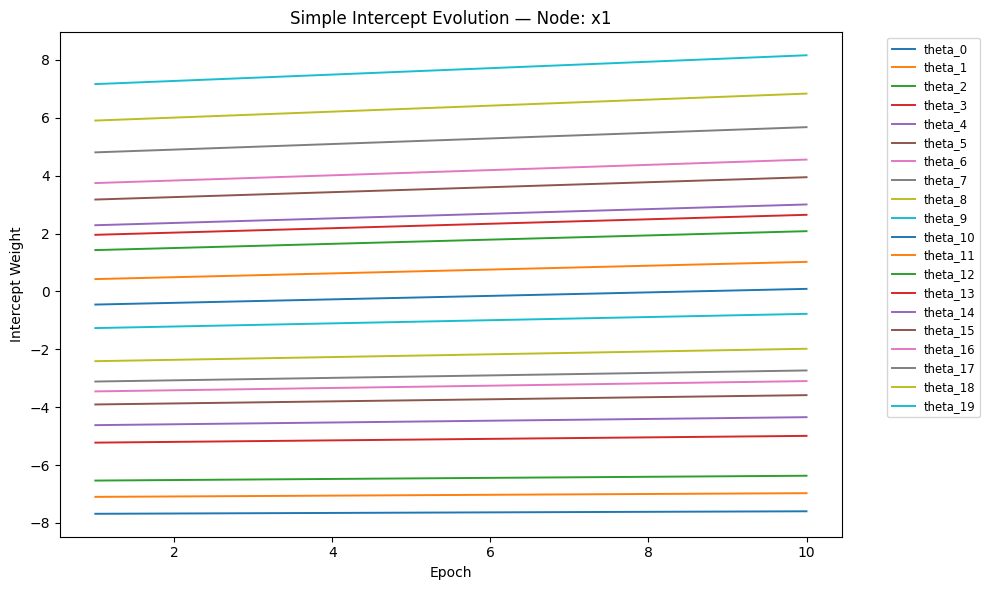

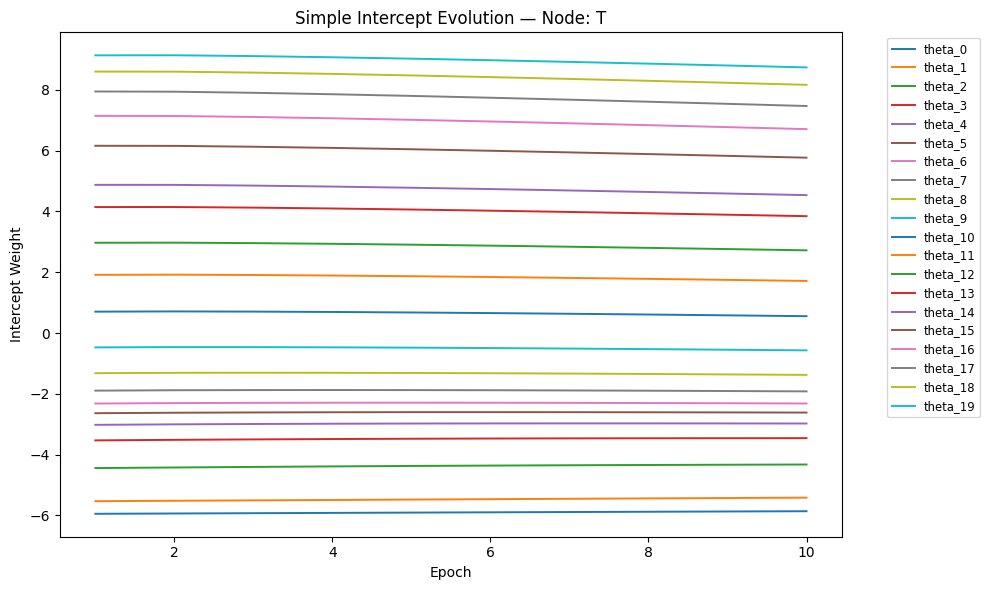

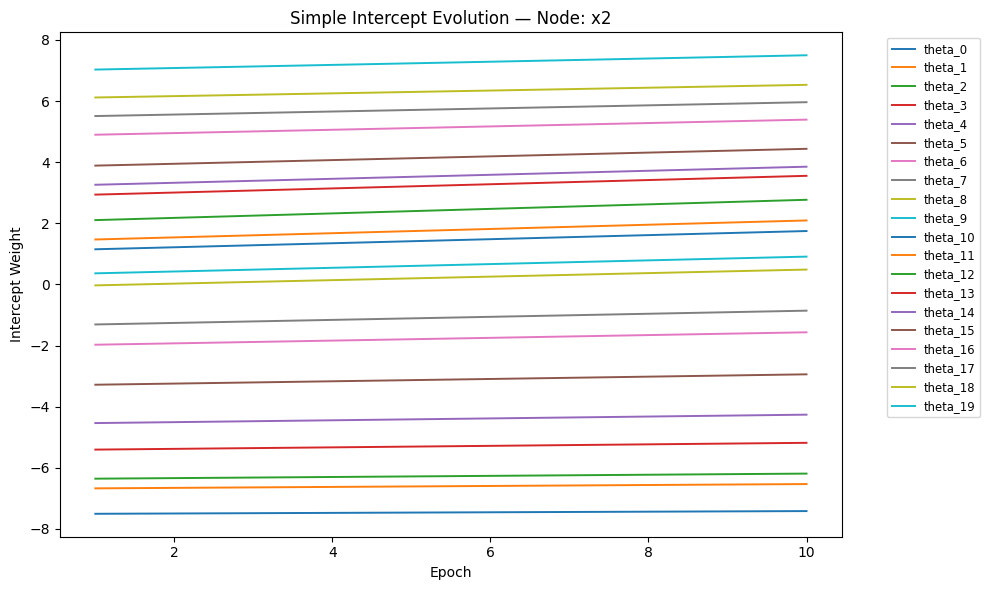

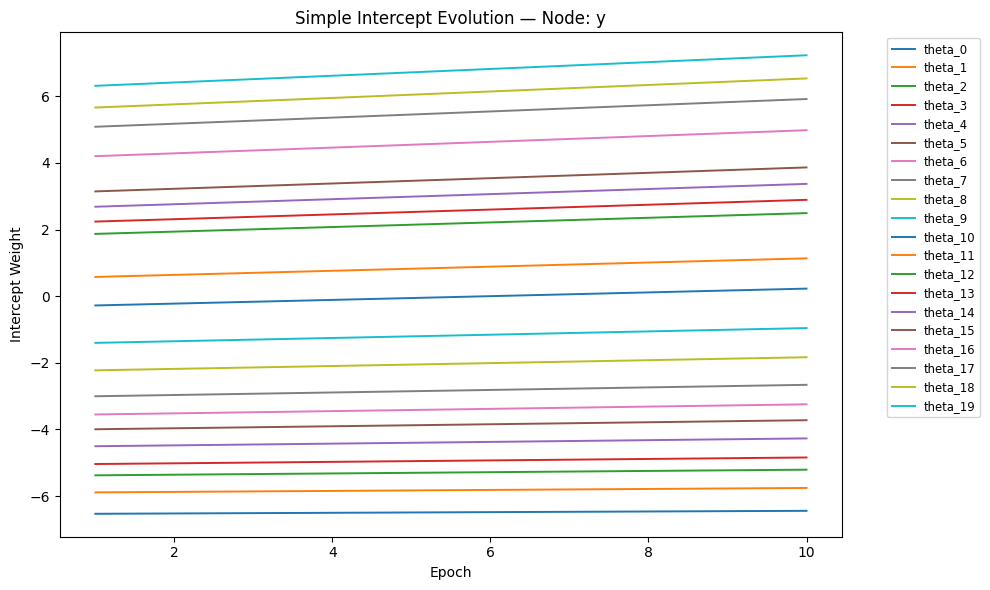

In [20]:
td_model.plot_simple_intercepts_history()

[WARNING] len(df)>1, function allows up to 5 rows to plot rest will be truncated, set: plot_n_rows accordingly
x1: Simple intercept — identical h() for all samples.


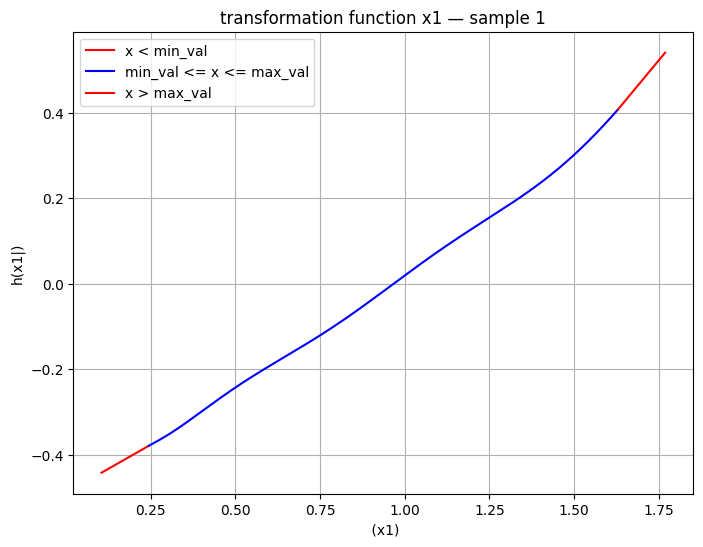


=== Sample 1/1 ===
x1    1.718275
T     1.000000
x2   -1.088962
y     7.060622
Name: 5, dtype: float64


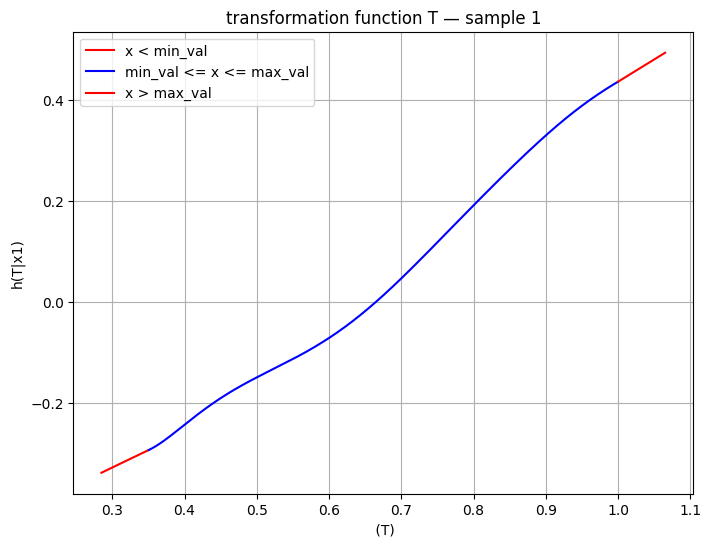


=== Sample 1/1 ===
x1    1.718275
T     1.000000
x2   -1.088962
y     7.060622
Name: 5, dtype: float64


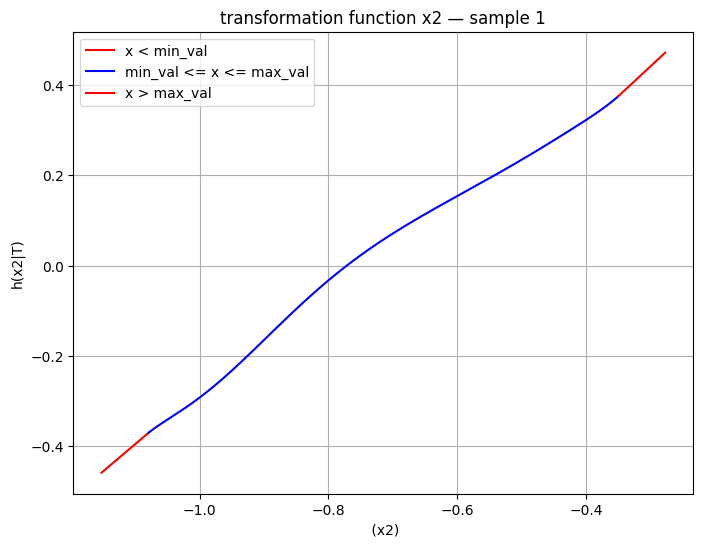


=== Sample 1/1 ===
x1    1.718275
T     1.000000
x2   -1.088962
y     7.060622
Name: 5, dtype: float64


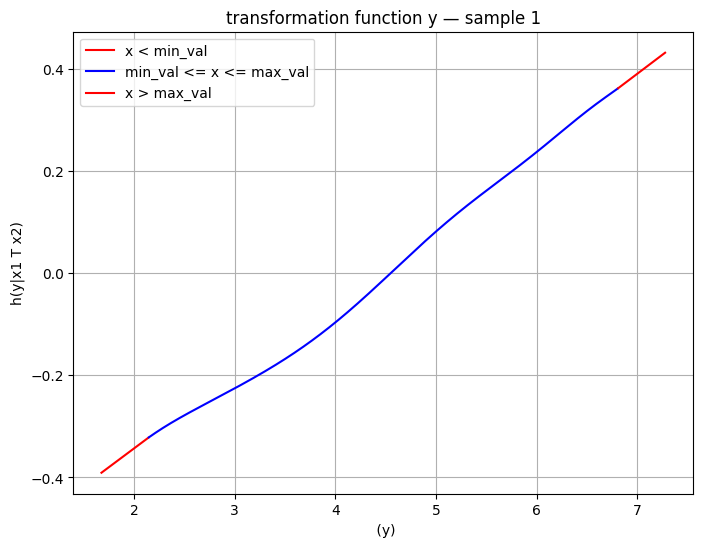

In [25]:
td_model.plot_hdag(df=train_df,plot_n_rows=1)

In [22]:
# samples, latents = td_model.sample()
# td_model.plot_samples_vs_true(train_df,samples)

In [23]:
td_model.load_or_compute_minmax(td_train_data=train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to exp_untrained_initweigths/min_max_scaling.json


In [24]:
u_training = td_model.get_latent(new_df)

NameError: name 'new_df' is not defined

In [ ]:
u_training

# x1 initial
[[ 0.7819,  0.8220, -0.4587,  0.0664,  0.4119,  0.0474, -0.4761, -0.7607,
          0.5883,  0.8094, -0.4682,  0.1614, -0.0074,  0.3666,  0.1630,  0.3283,
          0.1295,  0.8200,  0.1547,  0.8975]

# x1 after laoding
theta tilde tensor([ 0.7819,  0.8220, -0.4587,  0.0664,  0.4119,  0.0474, -0.4761, -0.7607,
         0.5883,  0.8094, -0.4682,  0.1614, -0.0074,  0.3666,  0.1630,  0.3283,
         0.1295,  0.8200,  0.1547,  0.8975])

# y initial
[[-0.4953, -0.1167,  0.2786,  0.0048, -0.1355,  0.2915, -0.5946, -0.7464,
         -0.2301,  0.8483,  0.4225, -0.2069, -0.2292,  0.6752,  0.6897, -0.2655,
         -0.2066,  0.5927, -0.9073,  0.7601]

# y after laoding 

theta tilde tensor([[-0.4953, -0.1167,  0.2786,  0.0048, -0.1355,  0.2915, -0.5946, -0.7464,
         -0.2301,  0.8483,  0.4225, -0.2069, -0.2292,  0.6752,  0.6897, -0.2655,
         -0.2066,  0.5927, -0.9073,  0.7601],

In [ ]:
samples, latents = td_model.sample(predefined_latent_samples_df=u_training)

In [ ]:
td_model.plot_samples_vs_true(train_df,samples)

In [ ]:
row = train_df.loc[0].copy()
row['y'] = 15

new_df = pd.DataFrame([row])
new_df


# TODO implement show h for 

In [ ]:
row = train_df.loc[0].copy()
row['y'] = 15

In [ ]:
train_df

train_df['']

In [ ]:
u_training

In [ ]:
samples

In [ ]:
## Show hdag
#TODO hdag plotting
# Continous case
# 1. for source nodes : all SI -> looks the same for all learned
#     - integrate already implemented function show_hdag for source nodes

# 2. for single observations of parents samples
#     - plot hdag
#     - fucniton accepts just up to 10 rows of data : plot for each 




In [ ]:
samples, latents = td_model.sample(predefined_latent_samples_df=u_training)
# inter_df=dgp(n_obs=10_000, doX=[-1.0,None , None])


In [ ]:
samples, latents = td_model.sample()

In [ ]:
u_training = td_model.get_latent(train_df)

In [ ]:
u_training.head()

In [ ]:
train_df.head()

In [ ]:
# Make cross tab of T and x1
train_df['T']

In [ ]:
############### !!!!!!!!!!!!!!!!!!!!!!!!! #######################################################
u_training = td_model.get_latent(train_df)
samples_doT1, latents_doT1 = td_model.sample(do_interventions={'T':1.0}, predefined_latent_samples_df=u_training)
#################################################################################################

In [ ]:
type(samples_doT1_with_T1)

In [ ]:
# Create a data frame from samples_doT1
samples_doT1_df = pd.DataFrame(samples_doT1)
print(samples_doT1_df.shape)
samples_doT1_df.head()
# Sahpe of samples_doT1_df
samples_doT1_df.shape, train_df.shape

# Extract the rows where T=1 from train_df and samples_doT1_df
mask = train_df['T'] == 1
train_with_T1 = train_df[mask]
samples_doT1_with_T1 = samples_doT1_df[mask.values]

train_with_T1.shape, samples_doT1_with_T1.shape
np.sum(train_with_T1['T'] == 1)
samples_doT1_with_T1['T']

In [ ]:
np.mean(train_with_T1['T'] > 0.5)
samples_doT1_with_T1


In [ ]:
train_with_T1['T']

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(samples_doT1_with_T1['x1'], train_with_T1['x1'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.xlabel('samples_doT1_with_T1 x1')
plt.ylabel('train_with_T1 x1')
plt.show()


plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('x2')
plt.scatter(samples_doT1_with_T1['x2'], train_with_T1['x2'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('y')
plt.scatter(samples_doT1_with_T1['y'], train_with_T1['y'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()



In [ ]:
data_doT1